# Analyzing Fitbit-data in R
This notebook requires you to use the [*Fitbit* connection](https://www.openhumans.org/activity/fitbit-connection/) to get your activity data into Open Humans. 

Given that the imported Fitbit data has a rather particular *JSON* format this notebook just gives an idea of how to extract individual data from the larger data set.

For a start let's load our required packages.

In [1]:
library(httr)
library(jsonlite)
library(ggplot2)
library(tidyverse)

Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


With that out of the way we can find the *Fitbit* data from our Open Humans account:

In [2]:
access_token <- Sys.getenv("OH_ACCESS_TOKEN")
url <- paste("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token=",access_token,sep="")
resp <- GET(url)
user <- content(resp, "parsed")

for (data_source in user$data){
    if (data_source$source == "direct-sharing-102"){
         fitbit_url <- data_source$download_url
    }
}

temp <- tempfile()
download.file(fitbit_url,temp,method='wget')
json_data <- fromJSON(temp)

Now that we have our fitbit data stored in json_data we can start to extract individual data types from it.

We should probably figure out the data sets present in our `json_data`. 

In [5]:
names(json_data)

[1] "activities-overview"            "tracker-minutes-very-active"   
 [3] "minutes-to-sleep"               "awake-minutes"                 
 [5] "sleep-efficiency"               "sleep-awakenings"              
 [7] "heart"                          "tracker-minutes-fairly-active" 
 [9] "sleep-minutes-after-wakeup"     "tracker-minutes-lightly-active"
[11] "sleep-minutes"                  "tracker-steps"                 
[13] "weight"                         "tracker-activity-calories"     
[15] "tracker-elevation"              "tracker-calories"              
[17] "tracker-minutes-sedentary"      "tracker-distance"              
[19] "time-in-bed"                    "weight-log"                    
[21] "tracker-floors"                 "profile"                       
[23] "sleep-start-time"

Let's focus on steps for now. We know from checking names above that steps is in the `tracker-steps` list. 

We can use the `flatten_df` function from `purrr` (installed with `tidyverse`) to remove the hierachy present in the `tracker-steps` list. We then do a bit of manipulation to set the variable formats (`value` as Numeric, `dateTime` as Date), rename `value` to `steps` (for ease of understanding) and then arrange by ascending dateTime.

In [27]:
steps_flat <- flatten_df(json_data$`tracker-steps`)

steps_flat <- flatten_df(json_data$`tracker-steps`)

fitbit_steps <- steps_flat %>% 
  mutate(value = as.numeric(value),
         dateTime = as.Date(dateTime)) %>% 
  rename(steps = value) %>% 
  arrange(., dateTime)


Let's check the structure of our new `fitbit_steps` data frame.

In [28]:
str(fitbit_steps)

'data.frame':	3652 obs. of  2 variables:
 $ steps   : num  43 0 0 0 0 0 0 0 0 0 ...
 $ dateTime: Date, format: "2009-01-01" "2009-01-02" ...


So we have steps, let's try another data set. How about minutes of vigorous activity present at `tracker-minutes-very-active`?

In [29]:
veryactive_flat <- flatten_df(json_data$`tracker-minutes-very-active`)

fitbit_veryactive <- veryactive_flat %>% 
  mutate(value = as.numeric(value),
         dateTime = as.Date(dateTime)) %>% 
  rename(veryactiveminutes = value) %>% 
  arrange(., dateTime)

str(fitbit_veryactive)

'data.frame':	3652 obs. of  2 variables:
 $ veryactiveminutes: num  0 0 0 0 0 0 0 0 0 0 ...
 $ dateTime         : Date, format: "2009-01-01" "2009-01-02" ...


Okay, how about we start exploration with plotting our steps. First we just need to load a few additional libraries to make our plots amazing.

In [30]:
library(scales)
library(lubridate)

Now just a bit of data manipulation to add some information to out data frame. 

In [31]:
fitbit_steps <- fitbit_steps  %>% 
  mutate(year = as.character(year(dateTime)))  %>% # creates year variable
  filter(year >= "2011")


steps,dateTime,year
0,2011-01-01,2011
0,2011-01-02,2011
0,2011-01-03,2011
0,2011-01-04,2011
0,2011-01-05,2011
0,2011-01-06,2011


,steps,dateTime,year
2917,0,2018-12-26,2018
2918,0,2018-12-27,2018
2919,0,2018-12-28,2018
2920,0,2018-12-29,2018
2921,0,2018-12-30,2018
2922,0,2018-12-31,2018


'data.frame':	2922 obs. of  3 variables:
 $ steps   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ dateTime: Date, format: "2011-01-01" "2011-01-02" ...
 $ year    : chr  "2011" "2011" "2011" "2011" ...


Now we can start our first plot: All of our daily steps

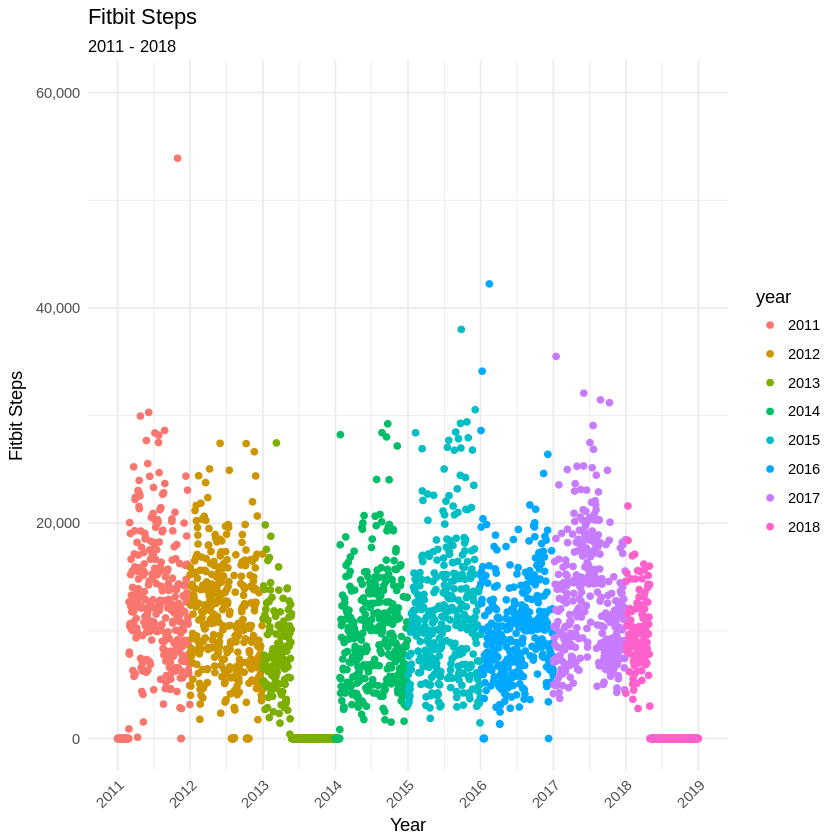

In [37]:
ggplot(fitbit_steps, aes(dateTime, steps, color = year)) +
  geom_point() +
  scale_x_date(breaks = date_breaks("1 year"), date_labels = "%Y") +
  scale_y_continuous(labels = comma, limits = c(0, 60000)) +
  labs(title = "Fitbit Steps",
       subtitle = "2011 - 2018",
       x = "Year", 
       y = "Fitbit Steps") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


Let's now also compare the daily step counts between the years. For this we generate `fake_date`s, which contain only the real `day` and `month` but are all normalized onto the same `year`. With that we can now plot everything onto a single `x-axis` by using the `fake_date` for it and still keep the `year`, using the variable of the same name:

In [46]:
fitbit_steps <- fitbit_steps  %>% 
  mutate(monthday = (format(dateTime,"%m-%d")),
         fakedate = as.Date(monthday, format = "%m-%d"))

`geom_smooth()` using method = 'loess'
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_path).”

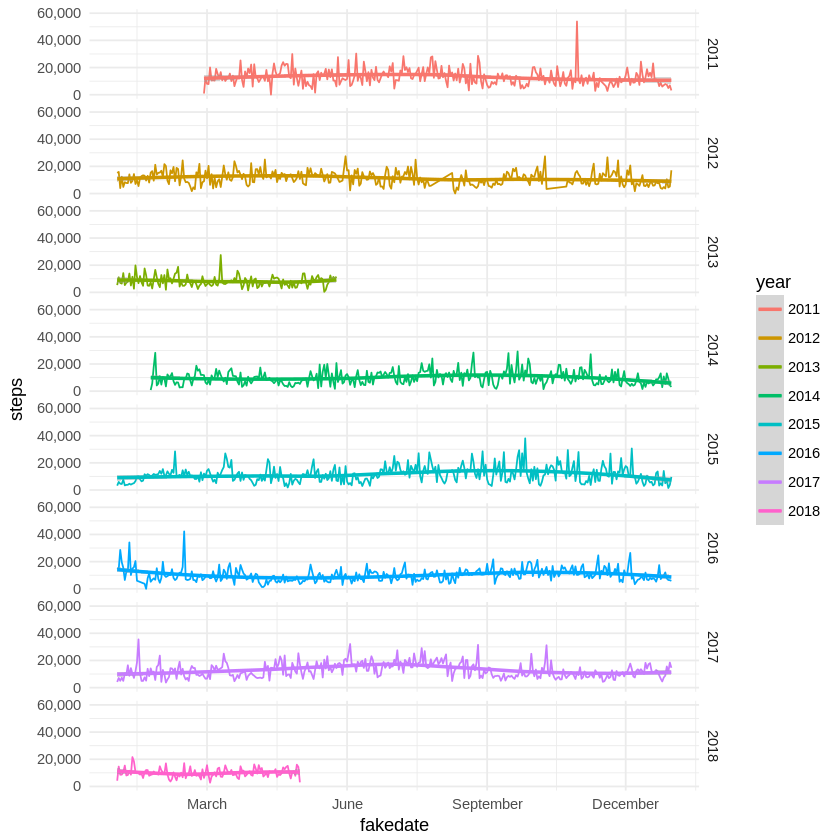

In [48]:
#df$date_wo_year <- as.character(format(as.Date(df$date),"%m-%d"))
#df$fake_date <- as.Date(paste('2001',df$date_wo_year,sep='-'))

#ggplot(subset(df,df$steps != 0),aes(fake_date,steps,color=year)) + 
 #   geom_line() + stat_smooth() + facet_grid(year ~ .) + 
#    theme_minimal()

ggplot(subset(fitbit_steps, fitbit_steps$steps != 0),aes(fakedate, steps, color = year)) + 
  geom_line() + 
  stat_smooth() + 
  scale_x_date(breaks = date_breaks("3 month"), date_labels = "%B") +
  scale_y_continuous(labels = comma, limits = c(0, 60000)) +
  facet_grid(year ~ .) + 
    theme_minimal()




And with that happy exploring!